In [6]:
import pandas as pd
import numpy as np
from scipy.io import arff
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [4]:
from scipy.io import arff
import pandas as pd


raw_data, meta = arff.loadarff(r'F:\Phd_Documents\ASD\src_p1\Autism-Child-Data.arff')


data = pd.DataFrame(raw_data)


for col in data.select_dtypes([object]).columns:
    data[col] = data[col].str.decode('utf-8')

print(data.head())


  A1_Score A2_Score A3_Score A4_Score A5_Score A6_Score A7_Score A8_Score  \
0        1        1        0        0        1        1        0        1   
1        1        1        0        0        1        1        0        1   
2        1        1        0        0        0        1        1        1   
3        0        1        0        0        1        1        0        0   
4        1        1        1        1        1        1        1        1   

  A9_Score A10_Score  ...  gender        ethnicity jundice austim  \
0        0         0  ...       m           Others      no     no   
1        0         0  ...       m  Middle Eastern       no     no   
2        0         0  ...       m                ?      no     no   
3        0         1  ...       f                ?     yes     no   
4        1         1  ...       m           Others     yes     no   

   contry_of_res used_app_before result    age_desc relation Class/ASD  
0         Jordan              no    5.0  4-11 yea

In [8]:
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


--- Fold 1 ---
2/2 [==============================] - 0s 0s/step
Accuracy: 1.0
ROC AUC: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


--- Fold 2 ---
2/2 [==============================] - 0s 3ms/step
Accuracy: 1.0
ROC AUC: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


--- Fold 3 ---
2/2 [==============================] - 0s 0s/step
Accuracy: 1.0
ROC AUC: 1.0
Classification Rep

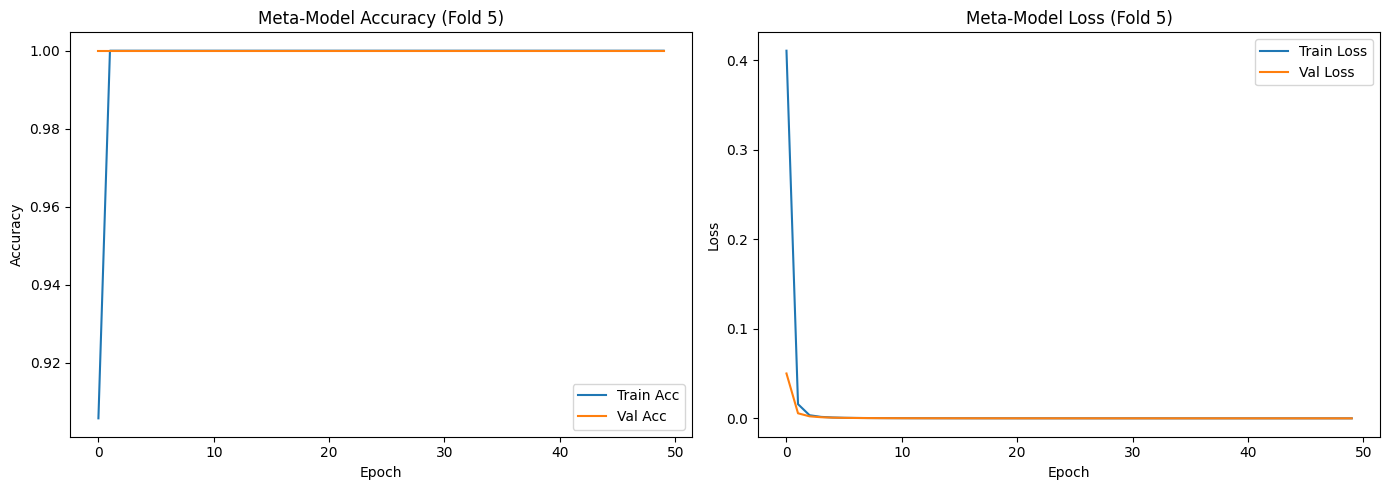

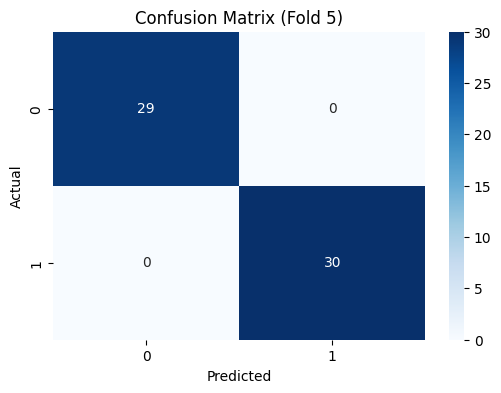

In [ ]:
raw_data, meta = arff.loadarff(r'F:\Phd_Documents\ASD\src_p1\Autism-Child-Data.arff')
data = pd.DataFrame(raw_data)

for col in data.select_dtypes([object]):
    data[col] = data[col].str.decode('utf-8')


data.drop(['ethnicity', 'contry_of_res', 'age_desc', 'relation'], axis=1, inplace=True)


data = data[data['age'] != 383]
data.replace("?", np.nan, inplace=True)
data.dropna(inplace=True)
data['age'] = data['age'].astype(float)


data['gender'] = data['gender'].map({'m': 1, 'f': 0})
data['jundice'] = data['jundice'].map({'yes': 1, 'no': 0})
data['austim'] = data['austim'].map({'yes': 1, 'no': 0})
data['used_app_before'] = data['used_app_before'].map({'yes': 1, 'no': 0})
data['Class/ASD'] = data['Class/ASD'].map({'YES': 1, 'NO': 0})


X = data[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score',
          'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score',
          'age', 'result', 'gender', 'jundice', 'austim']]
y = data['Class/ASD']


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs, aucs = [], []

fold = 1
for train_index, test_index in kf.split(X_resampled, y_resampled):
    print(f"\n--- Fold {fold} ---")
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]


    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    svm = SVC(probability=True, kernel='rbf', random_state=42)
    gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

    rf.fit(X_train, y_train)
    svm.fit(X_train, y_train)
    gbm.fit(X_train, y_train)

    meta_train = np.column_stack((
        rf.predict_proba(X_train)[:, 1],
        svm.predict_proba(X_train)[:, 1],
        gbm.predict_proba(X_train)[:, 1]
    ))

    meta_test = np.column_stack((
        rf.predict_proba(X_test)[:, 1],
        svm.predict_proba(X_test)[:, 1],
        gbm.predict_proba(X_test)[:, 1]
    ))


    tf.keras.backend.clear_session()
    meta_model = Sequential([
        Dense(8, input_dim=3, activation='relu'),
        Dense(4, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    meta_model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])


    history = meta_model.fit(meta_train, y_train.to_numpy(), epochs=50, batch_size=2, verbose=0, validation_split=0.2)


    preds = (meta_model.predict(meta_test) > 0.5).astype(int)

    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, preds)
    accs.append(acc)
    aucs.append(auc)

    print("Accuracy:", acc)
    print("ROC AUC:", auc)
    print("Classification Report:\n", classification_report(y_test, preds))


    if fold == 5:
        final_history = history
        final_y_test = y_test
        final_preds = preds

    fold += 1


print("\n=== Cross-Validation Summary ===")
print("Mean Accuracy:", np.mean(accs))
print("Mean ROC AUC:", np.mean(aucs))


plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'], label='Train Acc')
plt.plot(final_history.history['val_accuracy'], label='Val Acc')
plt.title('Meta-Model Accuracy (Fold 5)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'], label='Train Loss')
plt.plot(final_history.history['val_loss'], label='Val Loss')
plt.title('Meta-Model Loss (Fold 5)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


conf_matrix = confusion_matrix(final_y_test, final_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Fold 5)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



--- Fold 1 ---
Logistic Regression  | Acc: 0.9333 | AUC: 0.9833
Random Forest        | Acc: 1.0000 | AUC: 1.0000
SVM                  | Acc: 0.9000 | AUC: 0.9789
Gradient Boosting    | Acc: 1.0000 | AUC: 1.0000
KNN                  | Acc: 0.9500 | AUC: 0.9933
Naive Bayes          | Acc: 0.9333 | AUC: 0.9867


e:\ProgramData\Anaconda3\envs\asd\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP                  | Acc: 0.8667 | AUC: 0.9656

--- Fold 2 ---
Logistic Regression  | Acc: 0.9667 | AUC: 1.0000
Random Forest        | Acc: 1.0000 | AUC: 1.0000
SVM                  | Acc: 0.9500 | AUC: 1.0000
Gradient Boosting    | Acc: 1.0000 | AUC: 1.0000
KNN                  | Acc: 1.0000 | AUC: 1.0000
Naive Bayes          | Acc: 0.9667 | AUC: 0.9967


e:\ProgramData\Anaconda3\envs\asd\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP                  | Acc: 0.9667 | AUC: 0.9944

--- Fold 3 ---
Logistic Regression  | Acc: 1.0000 | AUC: 1.0000
Random Forest        | Acc: 1.0000 | AUC: 1.0000
SVM                  | Acc: 0.9667 | AUC: 0.9978
Gradient Boosting    | Acc: 1.0000 | AUC: 1.0000
KNN                  | Acc: 0.9167 | AUC: 0.9778
Naive Bayes          | Acc: 0.9333 | AUC: 0.9933


e:\ProgramData\Anaconda3\envs\asd\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP                  | Acc: 0.9833 | AUC: 1.0000

--- Fold 4 ---
Logistic Regression  | Acc: 0.9831 | AUC: 0.9989
Random Forest        | Acc: 1.0000 | AUC: 1.0000
SVM                  | Acc: 0.9322 | AUC: 0.9954
Gradient Boosting    | Acc: 1.0000 | AUC: 1.0000
KNN                  | Acc: 0.9153 | AUC: 0.9897
Naive Bayes          | Acc: 0.9661 | AUC: 0.9931


e:\ProgramData\Anaconda3\envs\asd\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP                  | Acc: 0.9661 | AUC: 0.9977

--- Fold 5 ---
Logistic Regression  | Acc: 0.9661 | AUC: 0.9977
Random Forest        | Acc: 1.0000 | AUC: 1.0000
SVM                  | Acc: 0.9322 | AUC: 0.9966
Gradient Boosting    | Acc: 1.0000 | AUC: 1.0000
KNN                  | Acc: 0.9322 | AUC: 0.9977
Naive Bayes          | Acc: 0.9831 | AUC: 0.9943


e:\ProgramData\Anaconda3\envs\asd\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP                  | Acc: 0.9492 | AUC: 0.9943

=== Cross-Validation Summary ===
                     Mean Accuracy  Mean ROC AUC
Random Forest             1.000000      1.000000
Gradient Boosting         1.000000      1.000000
Logistic Regression       0.969831      0.995977
SVM                       0.936215      0.993724
Naive Bayes               0.956497      0.992805
KNN                       0.942825      0.991693
MLP                       0.946384      0.990391


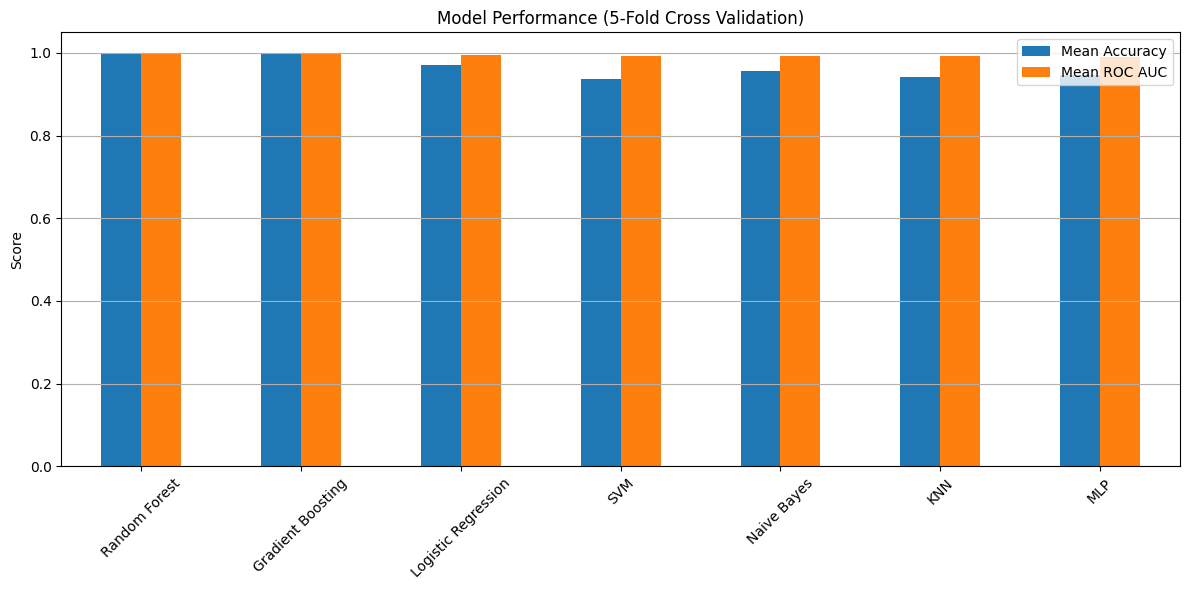

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier


raw_data, meta = arff.loadarff(r'F:\Phd_Documents\ASD\src_p1\Autism-Child-Data.arff')
data = pd.DataFrame(raw_data)

for col in data.select_dtypes([object]):
    data[col] = data[col].str.decode('utf-8')


data.drop(['ethnicity', 'contry_of_res', 'age_desc', 'relation'], axis=1, inplace=True)


data = data[data['age'] != 383]
data.replace("?", np.nan, inplace=True)
data.dropna(inplace=True)
data['age'] = data['age'].astype(float)

data['gender'] = data['gender'].map({'m': 1, 'f': 0})
data['jundice'] = data['jundice'].map({'yes': 1, 'no': 0})
data['austim'] = data['austim'].map({'yes': 1, 'no': 0})
data['used_app_before'] = data['used_app_before'].map({'yes': 1, 'no': 0})
data['Class/ASD'] = data['Class/ASD'].map({'YES': 1, 'NO': 0})


X = data[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score',
          'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score',
          'age', 'result', 'gender', 'jundice', 'austim']]
y = data['Class/ASD']


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)


classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, kernel='rbf', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
}


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {name: {'acc': [], 'auc': []} for name in classifiers}

for fold, (train_index, test_index) in enumerate(kf.split(X_resampled, y_resampled), 1):
    print(f"\n--- Fold {fold} ---")
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

    for name, model in classifiers.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, preds)
        auc = roc_auc_score(y_test, probs)

        results[name]['acc'].append(acc)
        results[name]['auc'].append(auc)

        print(f"{name:20} | Acc: {acc:.4f} | AUC: {auc:.4f}")

print("\n=== Cross-Validation Summary ===")
summary_df = pd.DataFrame({
    model: {
        "Mean Accuracy": np.mean(metrics["acc"]),
        "Mean ROC AUC": np.mean(metrics["auc"])
    } for model, metrics in results.items()
}).T.sort_values(by="Mean ROC AUC", ascending=False)

print(summary_df)


summary_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance (5-Fold Cross Validation)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



--- Fold 1 ---
Logistic Regression  | Acc: 0.9479 | AUC: 0.9552
Random Forest        | Acc: 0.9485 | AUC: 0.9773
SVM                  | Acc: 0.9544 | AUC: 0.9731
Gradient Boosting    | Acc: 0.9374 | AUC: 0.9611
KNN                  | Acc: 0.9298 | AUC: 0.9570
Naive Bayes          | Acc: 0.9157 | AUC: 0.9517
MLP                  | Acc: 0.9520 | AUC: 0.9778

--- Fold 2 ---
Logistic Regression  | Acc: 0.9520 | AUC: 0.9604
Random Forest        | Acc: 0.9590 | AUC: 0.9795
SVM                  | Acc: 0.9620 | AUC: 0.9703
Gradient Boosting    | Acc: 0.9508 | AUC: 0.9645
KNN                  | Acc: 0.9526 | AUC: 0.9689
Naive Bayes          | Acc: 0.9157 | AUC: 0.9562
MLP                  | Acc: 0.9631 | AUC: 0.9792

--- Fold 3 ---
Logistic Regression  | Acc: 0.9502 | AUC: 0.9602
Random Forest        | Acc: 0.9514 | AUC: 0.9798
SVM                  | Acc: 0.9561 | AUC: 0.9739
Gradient Boosting    | Acc: 0.9479 | AUC: 0.9660
KNN                  | Acc: 0.9391 | AUC: 0.9623
Naive Bayes          

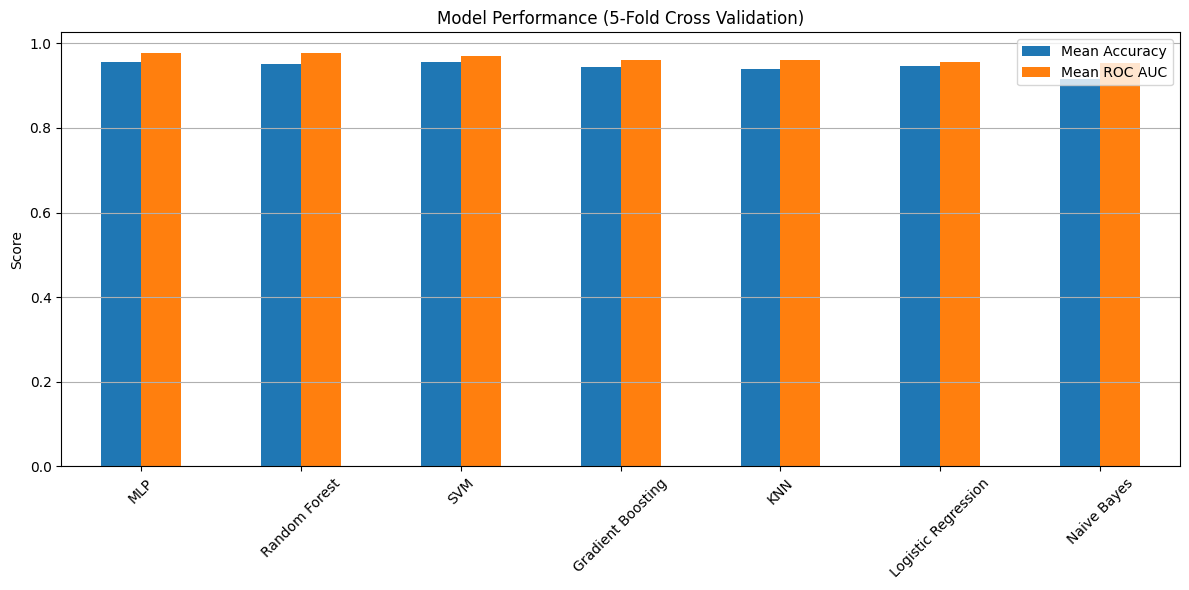

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier


df = pd.read_csv("F:\Phd_Documents\ASD\src_p1\Autism_Screening_Data_Combined.csv")  


df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)


df['Sex'] = df['Sex'].map({'m': 1, 'f': 0})
df['Jauundice'] = df['Jauundice'].map({'yes': 1, 'no': 0})
df['Family_ASD'] = df['Family_ASD'].map({'yes': 1, 'no': 0})
df['Class'] = df['Class'].map({'YES': 1, 'NO': 0})


X = df[['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
        'Age', 'Sex', 'Jauundice', 'Family_ASD']]
y = df['Class']


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)


classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, kernel='rbf', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
}


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {name: {'acc': [], 'auc': []} for name in classifiers}

for fold, (train_idx, test_idx) in enumerate(kf.split(X_resampled, y_resampled), 1):
    print(f"\n--- Fold {fold} ---")
    X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

    for name, model in classifiers.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, preds)
        auc = roc_auc_score(y_test, probs)

        results[name]['acc'].append(acc)
        results[name]['auc'].append(auc)

        print(f"{name:20} | Acc: {acc:.4f} | AUC: {auc:.4f}")


print("\n=== Cross-Validation Summary ===")
summary_df = pd.DataFrame({
    model: {
        "Mean Accuracy": np.mean(metrics["acc"]),
        "Mean ROC AUC": np.mean(metrics["auc"])
    } for model, metrics in results.items()
}).T.sort_values(by="Mean ROC AUC", ascending=False)

print(summary_df)


summary_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance (5-Fold Cross Validation)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



--- Fold 1 ---
Logistic Regression  | Acc: 0.9479 | AUC: 0.9552
Random Forest        | Acc: 0.9485 | AUC: 0.9773
SVM                  | Acc: 0.9544 | AUC: 0.9731
Gradient Boosting    | Acc: 0.9374 | AUC: 0.9611
KNN                  | Acc: 0.9298 | AUC: 0.9570
Naive Bayes          | Acc: 0.9157 | AUC: 0.9517
MLP                  | Acc: 0.9520 | AUC: 0.9778
54/54 [==============================] - 0s 885us/step
Proposed Ensemble    | Acc: 0.9485 | AUC: 0.9776

--- Fold 2 ---
Logistic Regression  | Acc: 0.9520 | AUC: 0.9604
Random Forest        | Acc: 0.9590 | AUC: 0.9795
SVM                  | Acc: 0.9620 | AUC: 0.9703
Gradient Boosting    | Acc: 0.9508 | AUC: 0.9645
KNN                  | Acc: 0.9526 | AUC: 0.9689
Naive Bayes          | Acc: 0.9157 | AUC: 0.9562
MLP                  | Acc: 0.9631 | AUC: 0.9792
54/54 [==============================] - 0s 930us/step
Proposed Ensemble    | Acc: 0.9585 | AUC: 0.9805

--- Fold 3 ---
Logistic Regression  | Acc: 0.9502 | AUC: 0.9602
Random Fo

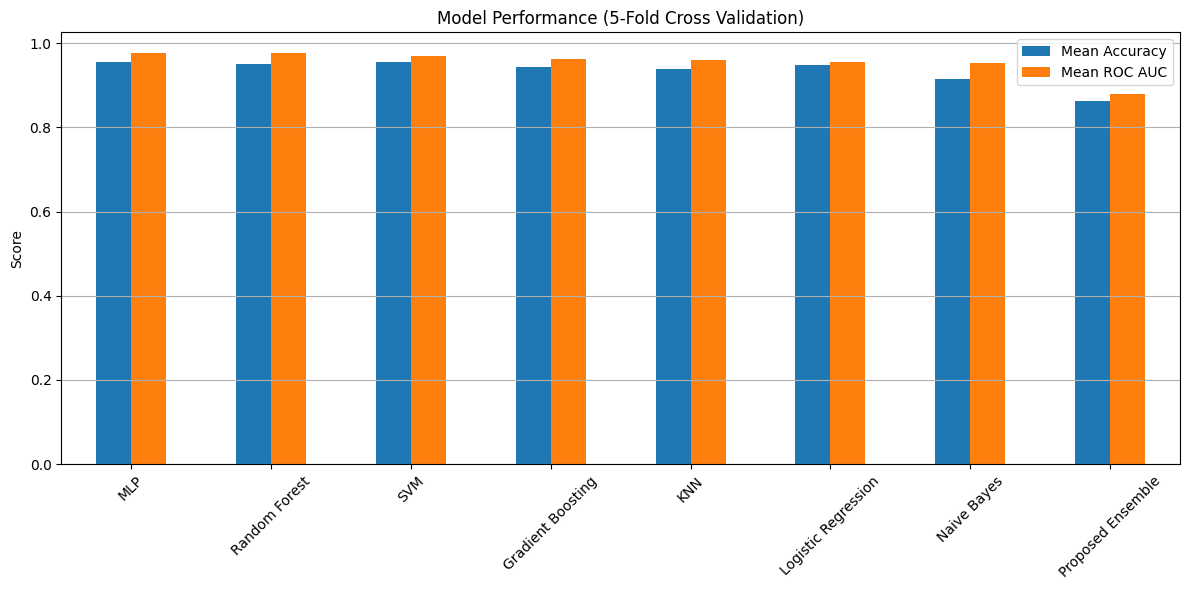

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


df = pd.read_csv(r"F:\Phd_Documents\ASD\src_p1\Autism_Screening_Data_Combined.csv")


df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)

df['Sex'] = df['Sex'].map({'m': 1, 'f': 0})
df['Jauundice'] = df['Jauundice'].map({'yes': 1, 'no': 0})
df['Family_ASD'] = df['Family_ASD'].map({'yes': 1, 'no': 0})
df['Class'] = df['Class'].map({'YES': 1, 'NO': 0})

X = df[['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
        'Age', 'Sex', 'Jauundice', 'Family_ASD']]
y = df['Class']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)


rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(probability=True, kernel='rbf', random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)


classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": rf,
    "SVM": svm,
    "Gradient Boosting": gb,
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42),
    "Proposed Ensemble": None  
}

results = {name: {'acc': [], 'auc': []} for name in classifiers}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(X_resampled, y_resampled), 1):
    print(f"\n--- Fold {fold} ---")
    X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

    for name, model in classifiers.items():
        if name == "Proposed Ensemble":
            
            rf.fit(X_train, y_train)
            svm.fit(X_train, y_train)
            gb.fit(X_train, y_train)

            
            meta_train = np.column_stack((
                rf.predict_proba(X_train)[:, 1],
                svm.predict_proba(X_train)[:, 1],
                gb.predict_proba(X_train)[:, 1]
            ))

            meta_test = np.column_stack((
                rf.predict_proba(X_test)[:, 1],
                svm.predict_proba(X_test)[:, 1],
                gb.predict_proba(X_test)[:, 1]
            ))

            
            tf.keras.backend.clear_session()
            meta_model = Sequential([
                Dense(8, input_dim=3, activation='relu'),
                Dense(4, activation='relu'),
                Dense(1, activation='sigmoid')
            ])
            meta_model.compile(optimizer=Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])
            meta_model.fit(meta_train, y_train.to_numpy(), epochs=50, batch_size=4, verbose=0)

            preds = (meta_model.predict(meta_test) > 0.5).astype(int).flatten()
            probs = meta_model.predict(meta_test).flatten()
        else:
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            probs = model.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, preds)
        auc = roc_auc_score(y_test, probs)
        results[name]['acc'].append(acc)
        results[name]['auc'].append(auc)

        print(f"{name:20} | Acc: {acc:.4f} | AUC: {auc:.4f}")


print("\n=== Cross-Validation Summary ===")
summary_df = pd.DataFrame({
    model: {
        "Mean Accuracy": np.mean(metrics["acc"]),
        "Mean ROC AUC": np.mean(metrics["auc"])
    } for model, metrics in results.items()
}).T.sort_values(by="Mean ROC AUC", ascending=False)

print(summary_df)


summary_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance (5-Fold Cross Validation)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



--- Fold 1 ---
Logistic Regression  | Acc: 0.9333 | AUC: 0.9833
Random Forest        | Acc: 1.0000 | AUC: 1.0000
SVM                  | Acc: 0.9000 | AUC: 0.9789
Gradient Boosting    | Acc: 1.0000 | AUC: 1.0000
KNN                  | Acc: 0.9500 | AUC: 0.9933
Naive Bayes          | Acc: 0.9333 | AUC: 0.9867


e:\ProgramData\Anaconda3\envs\asd\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP                  | Acc: 0.8667 | AUC: 0.9656
Proposed Ensemble    | Acc: 1.0000 | AUC: 1.0000

--- Fold 2 ---
Logistic Regression  | Acc: 0.9667 | AUC: 1.0000
Random Forest        | Acc: 1.0000 | AUC: 1.0000
SVM                  | Acc: 0.9500 | AUC: 1.0000
Gradient Boosting    | Acc: 1.0000 | AUC: 1.0000
KNN                  | Acc: 1.0000 | AUC: 1.0000
Naive Bayes          | Acc: 0.9667 | AUC: 0.9967


e:\ProgramData\Anaconda3\envs\asd\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP                  | Acc: 0.9667 | AUC: 0.9944
Proposed Ensemble    | Acc: 1.0000 | AUC: 1.0000

--- Fold 3 ---
Logistic Regression  | Acc: 1.0000 | AUC: 1.0000
Random Forest        | Acc: 1.0000 | AUC: 1.0000
SVM                  | Acc: 0.9667 | AUC: 0.9978
Gradient Boosting    | Acc: 1.0000 | AUC: 1.0000
KNN                  | Acc: 0.9167 | AUC: 0.9778
Naive Bayes          | Acc: 0.9333 | AUC: 0.9933


e:\ProgramData\Anaconda3\envs\asd\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP                  | Acc: 0.9833 | AUC: 1.0000
Proposed Ensemble    | Acc: 1.0000 | AUC: 1.0000

--- Fold 4 ---
Logistic Regression  | Acc: 0.9831 | AUC: 0.9989
Random Forest        | Acc: 1.0000 | AUC: 1.0000
SVM                  | Acc: 0.9322 | AUC: 0.9954
Gradient Boosting    | Acc: 1.0000 | AUC: 1.0000
KNN                  | Acc: 0.9153 | AUC: 0.9897
Naive Bayes          | Acc: 0.9661 | AUC: 0.9931


e:\ProgramData\Anaconda3\envs\asd\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP                  | Acc: 0.9661 | AUC: 0.9977
Proposed Ensemble    | Acc: 1.0000 | AUC: 1.0000

--- Fold 5 ---
Logistic Regression  | Acc: 0.9661 | AUC: 0.9977
Random Forest        | Acc: 1.0000 | AUC: 1.0000
SVM                  | Acc: 0.9322 | AUC: 0.9966
Gradient Boosting    | Acc: 1.0000 | AUC: 1.0000
KNN                  | Acc: 0.9322 | AUC: 0.9977
Naive Bayes          | Acc: 0.9831 | AUC: 0.9943


e:\ProgramData\Anaconda3\envs\asd\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP                  | Acc: 0.9492 | AUC: 0.9943
Proposed Ensemble    | Acc: 1.0000 | AUC: 1.0000

=== Cross-Validation Summary ===
                     Mean Accuracy  Mean ROC AUC
Random Forest             1.000000      1.000000
Gradient Boosting         1.000000      1.000000
Proposed Ensemble         1.000000      1.000000
Logistic Regression       0.969831      0.995977
SVM                       0.936215      0.993724
Naive Bayes               0.956497      0.992805
KNN                       0.942825      0.991693
MLP                       0.946384      0.990391


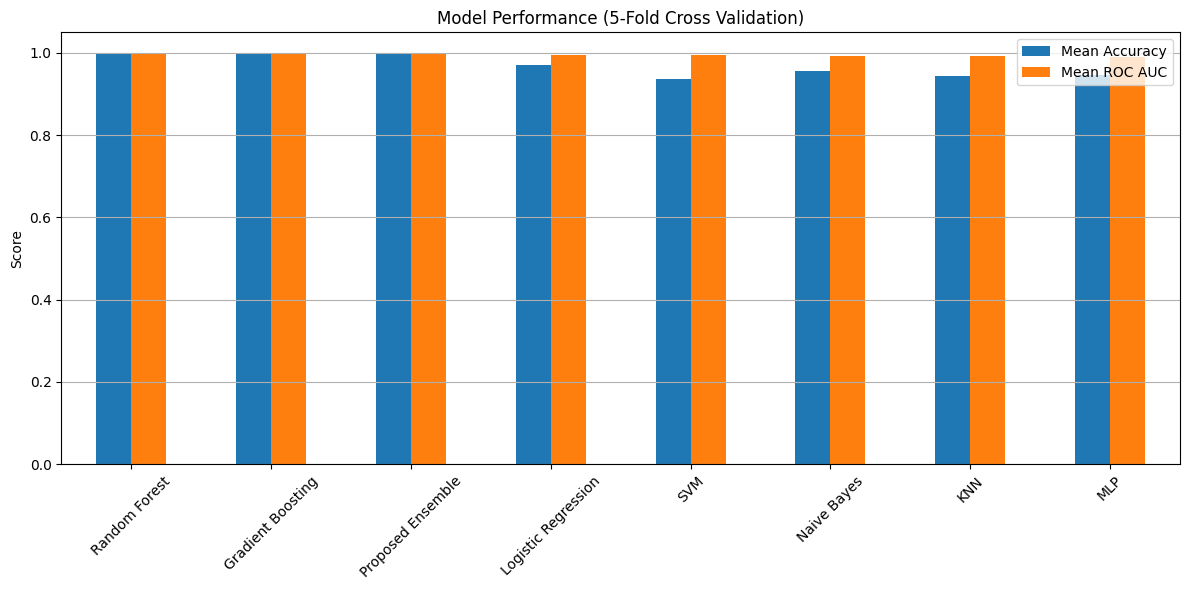

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier


raw_data, meta = arff.loadarff(r'F:\Phd_Documents\ASD\src_p1\Autism-Child-Data.arff')
data = pd.DataFrame(raw_data)


for col in data.select_dtypes([object]):
    data[col] = data[col].str.decode('utf-8')


data.drop(['ethnicity', 'contry_of_res', 'age_desc', 'relation'], axis=1, inplace=True)


data = data[data['age'] != 383]
data.replace("?", np.nan, inplace=True)
data.dropna(inplace=True)
data['age'] = data['age'].astype(float)

data['gender'] = data['gender'].map({'m': 1, 'f': 0})
data['jundice'] = data['jundice'].map({'yes': 1, 'no': 0})
data['austim'] = data['austim'].map({'yes': 1, 'no': 0})
data['used_app_before'] = data['used_app_before'].map({'yes': 1, 'no': 0})
data['Class/ASD'] = data['Class/ASD'].map({'YES': 1, 'NO': 0})


X = data[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score',
          'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score',
          'age', 'result', 'gender', 'jundice', 'austim']]
y = data['Class/ASD']


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)


base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, kernel='rbf', random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42))
]


meta_learner = MLPClassifier(hidden_layer_sizes=(30,), max_iter=500, random_state=42)


stacked_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    passthrough=True,
    n_jobs=-1
)


classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, kernel='rbf', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42),
    "Proposed Ensemble": stacked_model
}


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {name: {'acc': [], 'auc': []} for name in classifiers}

for fold, (train_index, test_index) in enumerate(kf.split(X_resampled, y_resampled), 1):
    print(f"\n--- Fold {fold} ---")
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

    for name, model in classifiers.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, preds)
        auc = roc_auc_score(y_test, probs)

        results[name]['acc'].append(acc)
        results[name]['auc'].append(auc)

        print(f"{name:20} | Acc: {acc:.4f} | AUC: {auc:.4f}")


print("\n=== Cross-Validation Summary ===")
summary_df = pd.DataFrame({
    model: {
        "Mean Accuracy": np.mean(metrics["acc"]),
        "Mean ROC AUC": np.mean(metrics["auc"])
    } for model, metrics in results.items()
}).T.sort_values(by="Mean ROC AUC", ascending=False)

print(summary_df)


summary_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance (5-Fold Cross Validation)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
